In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 자연어처리 실습 문제

### 발화 상황 인식 하기

- 2_대화체.xlsx 파일에서 '한국어' 혹은 '영어' 둘 중 하나를 선택하여 대분류를 예측하는 모델 만들기
- 2_대화체.xlsx는 0_dataset 폴더에 있습니다.
- 데이터 분석(간단히), 전처리, 모델 빌드, 학습, 평가에 거쳐 전체 코드를 작성하기

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_excel('../content/drive/MyDrive/conversation/2_conversation.xlsx')[['대분류', '번역문']]
df

,대분류,번역문
0,비즈니스,How is the market's reaction to the newly rele...
1,비즈니스,The sales increase is faster than the previous...
2,비즈니스,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,"Sure, I'll make a call and double the volume o..."
4,비즈니스,Shall we take a look at the issues we discusse...
...,...,...
99995,여행/쇼핑,It seems that we didn't place the price tags c...
99996,여행/쇼핑,Can I pay using the department store points?
99997,여행/쇼핑,"Yes, of course, you just need to enter your ph..."
99998,여행/쇼핑,"I entered it, I want to pay it with all the de..."


In [ ]:
# 판다스 데이터 기본탐색
print(df[['대분류', '번역문']].head())
print(df[['대분류', '번역문']].tail())
print(df[['대분류', '번역문']].shape)
print(df[['대분류', '번역문']].columns)
print(df[['대분류', '번역문']].info())
print(df[['대분류', '번역문']].describe())

    대분류                                                번역문
0  비즈니스  How is the market's reaction to the newly rele...
1  비즈니스  The sales increase is faster than the previous...
2  비즈니스  Then, we'll have to call the manufacturer and ...
3  비즈니스  Sure, I'll make a call and double the volume o...
4  비즈니스  Shall we take a look at the issues we discusse...
         대분류                                                번역문
99995  여행/쇼핑  It seems that we didn't place the price tags c...
99996  여행/쇼핑       Can I pay using the department store points?
99997  여행/쇼핑  Yes, of course, you just need to enter your ph...
99998  여행/쇼핑  I entered it, I want to pay it with all the de...
99999  여행/쇼핑  I'm sorry, but you need to make a separate pay...
(100000, 2)
Index(['대분류', '번역문'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   대분류     100000 non-null 

## 1. 데이터 분석

- null, 중복 데이터 확인
- 클래스 별 데이터 수 비교
- 클래스 별 text를 각 10개씩 텍스트 출력

In [ ]:
print(df.isnull().sum()) # 결측치 개수 합계 확인
print(df[df.isnull().any(axis=1)]) #

대분류    0
번역문    0
dtype: int64
Empty DataFrame
Columns: [대분류, 번역문]
Index: []


In [ ]:
print(df.duplicated().sum())
df = df.drop_duplicates().reset_index(drop=True) # 중복 제거

73


In [ ]:
print(df['대분류'].value_counts())

대분류
여행/쇼핑    46484
비즈니스     28052
일상대화     23991
스포츠       1000
의학         400
Name: count, dtype: int64


In [ ]:
for category in df['대분류'].unique(): # 데이터프레임의 대분류 열만, unique 중복없이 모든 클래스 값을 가져옴
    print(f"\n 대분류: {category}") # 현재 반복 중인 카테고리 이름 출력
    texts = df[df['대분류'] == category]['번역문'].head(5) # 현재 카테고리에 해당하는 행만 필터링
    for i, text in enumerate(texts, 1): # test안에 1번부터 순번 붙여줌
        print(f"{i:2d}.{text}") # i는 번호, text는 내용 함께 출력
        # 2d 숫자를 2칸 고정 너비로 출력


 대분류: 비즈니스
 1.How is the market's reaction to the newly released product?
 2.The sales increase is faster than the previous product.
 3.Then, we'll have to call the manufacturer and increase the volume of orders.
 4.Sure, I'll make a call and double the volume of orders.
 5.Shall we take a look at the issues we discussed by the end of the last meeting?

 대분류: 일상대화
 1.Do you know which part our test is going to cover? I come to class last week.
 2.Yes. Our test will be from page 100 to page 250.
 3.I see, thanks! Did you have any additional information?
 4.Yes. The professor also told us to look at the presentation materials that he gave us last week.
 5.I'm currently analyzing the level of difficulties of our past exams. What do you think this exam will be like?

 대분류: 의학
 1.Hello, nice to meet you, what brings you here?
 2.I have fluid coming out of my right ear and I have pain inside the ear canal.
 3.Let's have a look. Do you have any fever or sore throat?
 4.I've had a little chil

## 2. 데이터 전처리

1. 데이터 전처리
    1. 데이터 토큰화
    1. 불용어, 노이즈 제거
    1. vocab 생성
    1. 데이터 벡터화(label encoding 및 패딩 추가)

1. 데이터 로더 준비
    1. 데이터 분할
    1. 데이터 셋 준비
    1. 데이터 로더 구축

In [ ]:
import os
dataset_path = "./content/drive/MyDrive/conversation/"
file_path = os.path.join(dataset_path, "2_conversation.xlsx")

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm

# 불용어 제거
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^ㄱ-ㅎ가-힣a-zA-Z0-9\s]', '', text)
    return text.strip() # 문자열 앞뒤 공백 제거

# 학습 로딩 + 전처리 + 라벨 인코딩 + 훈련/검증 + 분리
def load_conversation_data(file_path, test_size=0.2):
    df = pd.read_excel(file_path)

    df = df[['번역문', '대분류']].dropna() # 결측치 행은 제거, 데이터 성격에 따른 필요에 따라 적용
    df['text'] = df['번역문'].apply(clean_text) # 문자열로 클린 함수 처리

    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['대분류']) # 라벨 인코딩 처리

    # 학습/검증 분리
    x_train, x_val, y_train, y_val = train_test_split(
        df['text'], df['label'],
        test_size=test_size, random_state=500, stratify=df['label']
    )

    return x_train.tolist(), x_val.tolist(), y_train.tolist(), y_val.tolist(), label_encoder
    # 모델 학습에서 직접 사용하도록 list형태로 반환
    # 나중에 예측 결과 디코딩 할 수 있도록 label_encoder도 같이 반환

In [ ]:
file_path = "/content/drive/MyDrive/conversation/2_conversation.xlsx"

x_train, x_val, y_train, y_val, label_encoder = load_conversation_data(file_path)
#load_conversation_data 함수의 데이터셋 로딩 및 전처리 실행

print("sample print:", list(zip(x_train, y_train))[:5]) # 학습 텍스트와 라벨 쌍을 5개만 샘플 출력
print("class list:", label_encoder.classes_) # 클래스 리스트 출력

sample print: [('Its you who needs to clean the house today and not me', 4), ('Ok itll be delivered within 15 minutes', 2), ('Is the private room available as I would like to book a table', 2), ('The price is around 200000 won in the offseason and I used Air Canada', 2), ('I think it starts in January and lasts through the month', 2)]
class list: ['비즈니스' '스포츠' '여행/쇼핑' '의학' '일상대화']


## 3. 모델 구축

- 분류 모델 구축
- 모델은 GRU를 사용
- bidirection 적용 및 layer 수는 2개 이상
- MLP에는 dropout을 적용

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import nltk
# nltk.download('punkt')

# 토크나이저 정의, 소문자화 : 동일한 단어로 토큰 인식을 위해, 단어수 증가 , 차원 폭발 방지
# 모델은 대, 소문자 처리를 잘 못 배움
# 일반적인 텍스트 분류, 감성 분석에 사용
# 개체명 인식, 문체 분석, 감정 강조 시에는 하지 말 것
# BERT, GPT 등 사용은 사전의 토크나이저를 따를 것
def tokenize(texts):
    return [text.lower().split() for text in texts]

def build_vocab(tokenized_texts, min_freq=2):
    word_count = Counter() # 단어 개수를 세고 빈도수 저장 할 준비
    for tokens in tokenized_texts: # 문장하나의 단어들 토큰화
        word_count.update(tokens) # 이걸 카운터에 넣어주며 빈도수 누적

    vocab = {'<pad>': 0, '<unk>': 1} # 사전에 특수 토큰으로 등록함
    for word, freq in word_count.items(): # 위에서 계산한 단어별 빈도 쌍을 하나씩 꺼냄
        if freq >= min_freq: # 최소 빈도 값의 기준
            vocab[word] = len(vocab) # vocab에 새로운 단어 추가하면서 인덱스 부여
    return vocab

# 토큰을 인덱스 시퀸스로 바꾸고, 패딩 처리 (for 딥러닝 모델에 데이터 넣기 위함)
def text_to_sequence(tokens_list, vocab, max_len):
    # tokens_list 토큰화 된 문장 리스트, # vocab 단어 -> 숫자의 인덱스 사전,
    # max_len 시퀸스의 고정 길이(패딩 또는 잘라냄)
    sequences = []
    for tokens in tokens_list: # 문장 하나씩 처리할 것
        seq = [vocab.get(token, vocab['<unk>']) for token in tokens]
        # 토큰을 인덱스로 변환, 단어가 vocab에 없으면 unk 처리
        if len(seq) < max_len: # 맥스길이보다 seq길이가 작으면,
        # 맥스길이에서 seq길이를 뺀 나머지 공간만큼 pad추가
            seq += [vocab['<pad>']] * (max_len - len(seq))
        else:
            seq = seq[:max_len] # 맥스길이보다 길면 seq 잘라냄
        sequences.append(seq)
    return sequences

In [ ]:
sample_tokenized = tokenize(x_train[:200]) # train셋에서 sampling 추출해서 vocab 확인

vocab = build_vocab(sample_tokenized, min_freq=2)
print("vocab sample:", list(vocab.items())[:50])

vocab sample: [('<pad>', 0), ('<unk>', 1), ('its', 2), ('you', 3), ('who', 4), ('to', 5), ('the', 6), ('house', 7), ('today', 8), ('and', 9), ('not', 10), ('me', 11), ('ok', 12), ('itll', 13), ('be', 14), ('delivered', 15), ('within', 16), ('minutes', 17), ('is', 18), ('private', 19), ('room', 20), ('available', 21), ('as', 22), ('i', 23), ('would', 24), ('like', 25), ('book', 26), ('a', 27), ('price', 28), ('won', 29), ('in', 30), ('used', 31), ('air', 32), ('think', 33), ('it', 34), ('through', 35), ('need', 36), ('take', 37), ('test', 38), ('because', 39), ('im', 40), ('getting', 41), ('can', 42), ('with', 43), ('an', 44), ('english', 45), ('am', 46), ('sorry', 47), ('we', 48), ('will', 49)]


In [ ]:
# 기본 데이터셋 클래스
class TextDataset(Dataset):
    def __init__(self, sequences, labels): # 데이터셋 초기화, 학습할 입력 시퀸스들, 정답 라벨 리스트들
        self.sequences = sequences
        self.labels = labels

    def __len__(self): # len(dataset)했을 때 반환되는 값 정의, dataloader가 배치 돌릴 수량 참조
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx]), torch.tensor(self.labels[idx])
        # 입력 시퀸스 텐서로 변환, # 정답 레이블 텐서로 변환

In [ ]:
Dataset()

In [ ]:
class BiGRUClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers=2, dropout=0.3):
        super(BiGRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        # 입력된 단어 인덱스를 embed_dim 차원의 임베딩 벡터로 변환
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers=n_layers,
                          bidirectional=True, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Bidirectional 2배 사이즈, 순방향 + 역방향 출력을 concat
        # FC 분류용 최종 출력
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        # x : (batch_size, seq_len) 형태의 단어 인덱스 시퀸스
        # 출력 shape : (batch_size, seq_len, embed_dim)

        _, hidden = self.gru(embedded)
        # GRU 출력 output (시퀸스 마다의 문맥 정보)
        # shape : (batch, seq_len, hidden_dim * 2)
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        # 순방향과 역방향 마지막 상태만 concat
        out = self.dropout(hidden_cat)
        # 시퀸스의 마지막 시점 출력만 가져옴
        return self.fc(out)

## 4. 학습

- 학습 루프 작성
- train, val 학습 커브 플롯

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
import torch.optim as optim

def train_model(model, train_loader, val_loader, epochs, device):
    criterion = nn.CrossEntropyLoss() # 다중 분류, 소프트맥스 자동 적용
    optimizer = optim.Adam(model.parameters(), lr=1e-3) # 가중치 자동 업데이트

    for epoch in range(epochs):
        model.train() # 학습 모드 전환
        total_loss = 0

        for x_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device) # GPU전환

            optimizer.zero_grad() # 옵티마이저 초기화
            outputs = model(x_batch) # Forward 연산수행
            loss = criterion(outputs, y_batch) # 예측값과 정답 사이의 CE loss계산
            loss.backward() # 역전파
            optimizer.step() # 가중치 업데이트
            total_loss += loss.item() # 손실 누적 저장

        print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

        model.eval()
        preds, targets = [], []
        probes = []

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                outputs = model(x_val) # [bacth, num_classes]

                probes.extend(torch.softmax(outputs, dim=1).cpu().numpy())
                preds.extend(torch.argmax(outputs, dim=1).cpu().numpy()) # accuracy 계산 위해 이동
                targets.extend(y_val.cpu().numpy())

        # Accuracy, F1 score, report
        acc = accuracy_score(targets, preds)
        f1_macro = f1_score(targets, preds, average='macro')
        f1_weighted = f1_score(targets, preds, average='weighted')
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Macro: {f1_macro:.4f}, F1 Weighted: {f1_weighted:.4f}")
        print(classification_report(targets, preds, target_names=label_encoder.classes_))

        # ROC AUC 계산
        n_classes = len(label_encoder.classes_)
        y_true_bin = label_binarize(targets, classes=list(range(n_classes)))
        y_score = np.array(probes)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f"Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")

        plt.plot([0, 1], [0, 1], 'k--', label='Random')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Multi-class ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [ ]:
tokenized_train = tokenize(x_train)
tokenized_val = tokenize(x_val)

In [ ]:
vocab = build_vocab(tokenized_train, min_freq=2)
max_len = 50

In [ ]:
train_seq = text_to_sequence(tokenized_train, vocab, max_len)
val_seq = text_to_sequence(tokenized_val, vocab, max_len)

In [ ]:
train_dataset = TextDataset(train_seq, y_train)
val_dataset = TextDataset(val_seq, y_val)

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiGRUClassifier(vocab_size=len(vocab), embed_dim=100, hidden_dim=128, output_dim=len(label_encoder.classes_))
model.to(device)

BiGRUClassifier(
  (embedding): Embedding(10522, 100, padding_idx=0)
  (gru): GRU(100, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Epoch 1:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 1 Loss: 0.8437
Accuracy: 0.6777
F1 Macro: 0.4327, F1 Weighted: 0.6685
              precision    recall  f1-score   support

        비즈니스       0.68      0.65      0.67      5613
         스포츠       0.65      0.12      0.20       200
       여행/쇼핑       0.70      0.81      0.75      9305
          의학       0.00      0.00      0.00        80
        일상대화       0.62      0.49      0.55      4802

    accuracy                           0.68     20000
   macro avg       0.53      0.41      0.43     20000
weighted avg       0.67      0.68      0.67     20000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipython-input-29-3260044863.py:74: UserWarni

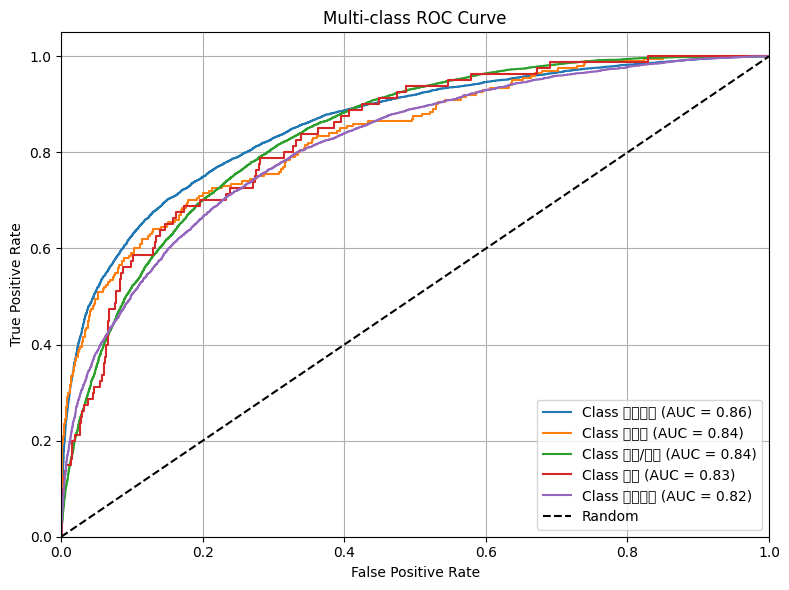

Epoch 2:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 2 Loss: 0.7186
Accuracy: 0.7000
F1 Macro: 0.4762, F1 Weighted: 0.6893
              precision    recall  f1-score   support

        비즈니스       0.71      0.66      0.69      5613
         스포츠       0.72      0.22      0.34       200
       여행/쇼핑       0.70      0.85      0.77      9305
          의학       0.17      0.01      0.02        80
        일상대화       0.68      0.48      0.56      4802

    accuracy                           0.70     20000
   macro avg       0.60      0.45      0.48     20000
weighted avg       0.70      0.70      0.69     20000



/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 52768 (\N{HANGUL SYLLABLE CEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  

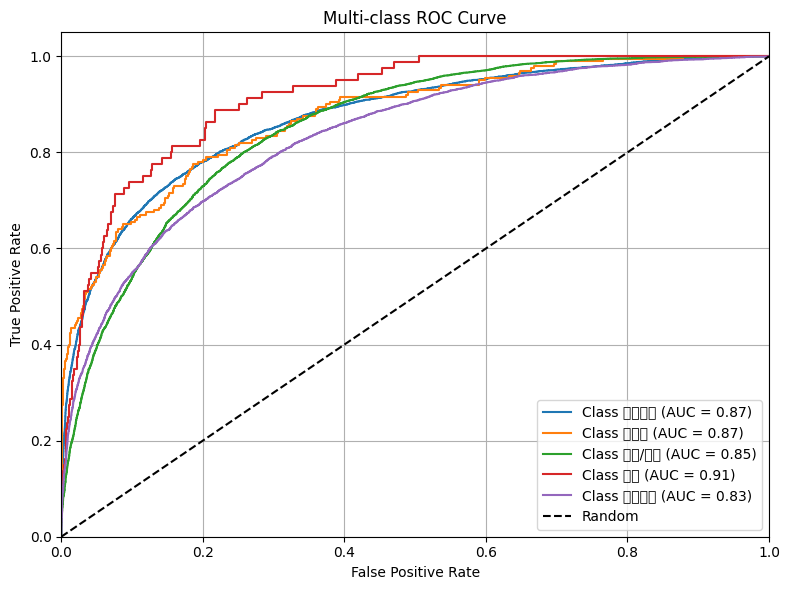

Epoch 3:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 3 Loss: 0.6303
Accuracy: 0.7021
F1 Macro: 0.5036, F1 Weighted: 0.6942
              precision    recall  f1-score   support

        비즈니스       0.73      0.65      0.69      5613
         스포츠       0.58      0.28      0.38       200
       여행/쇼핑       0.71      0.84      0.77      9305
          의학       0.31      0.06      0.10        80
        일상대화       0.65      0.52      0.58      4802

    accuracy                           0.70     20000
   macro avg       0.60      0.47      0.50     20000
weighted avg       0.70      0.70      0.69     20000



/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 52768 (\N{HANGUL SYLLABLE CEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  

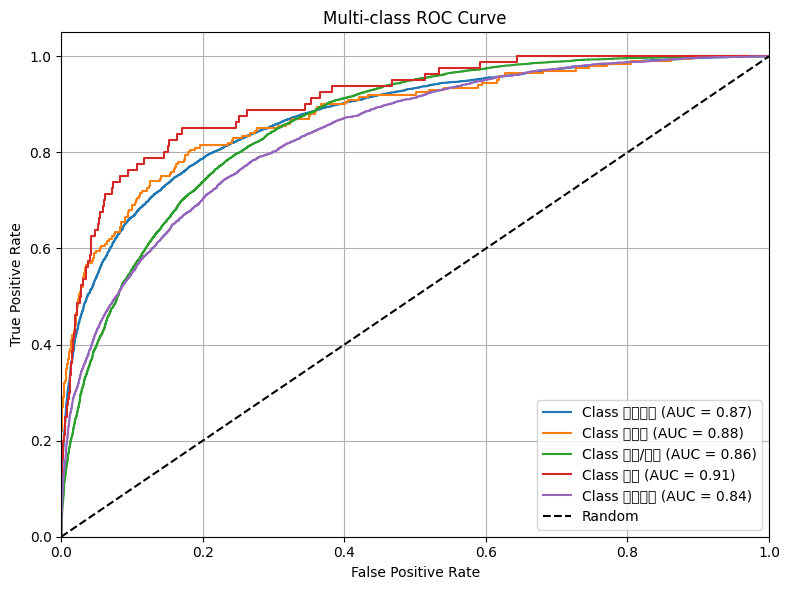

Epoch 4:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 4 Loss: 0.5484
Accuracy: 0.6995
F1 Macro: 0.5188, F1 Weighted: 0.6952
              precision    recall  f1-score   support

        비즈니스       0.72      0.65      0.69      5613
         스포츠       0.48      0.28      0.35       200
       여행/쇼핑       0.73      0.81      0.77      9305
          의학       0.31      0.15      0.20        80
        일상대화       0.61      0.57      0.59      4802

    accuracy                           0.70     20000
   macro avg       0.57      0.49      0.52     20000
weighted avg       0.70      0.70      0.70     20000



/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 52768 (\N{HANGUL SYLLABLE CEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  

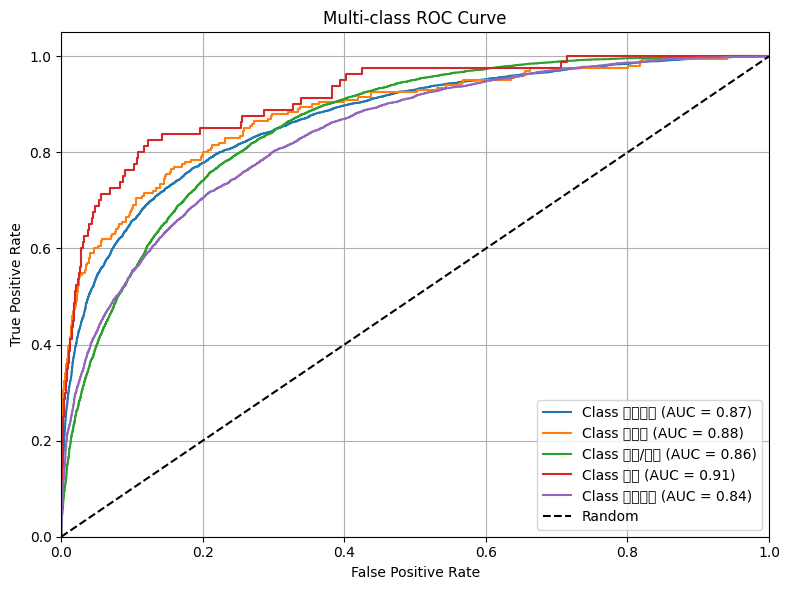

Epoch 5:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch 5 Loss: 0.4597
Accuracy: 0.6906
F1 Macro: 0.4970, F1 Weighted: 0.6868
              precision    recall  f1-score   support

        비즈니스       0.71      0.64      0.67      5613
         스포츠       0.50      0.26      0.34       200
       여행/쇼핑       0.73      0.79      0.76      9305
          의학       0.25      0.09      0.13        80
        일상대화       0.60      0.57      0.59      4802

    accuracy                           0.69     20000
   macro avg       0.56      0.47      0.50     20000
weighted avg       0.69      0.69      0.69     20000



/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 51592 (\N{HANGUL SYLLABLE JEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 52768 (\N{HANGUL SYLLABLE CEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-29-3260044863.py:74: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  

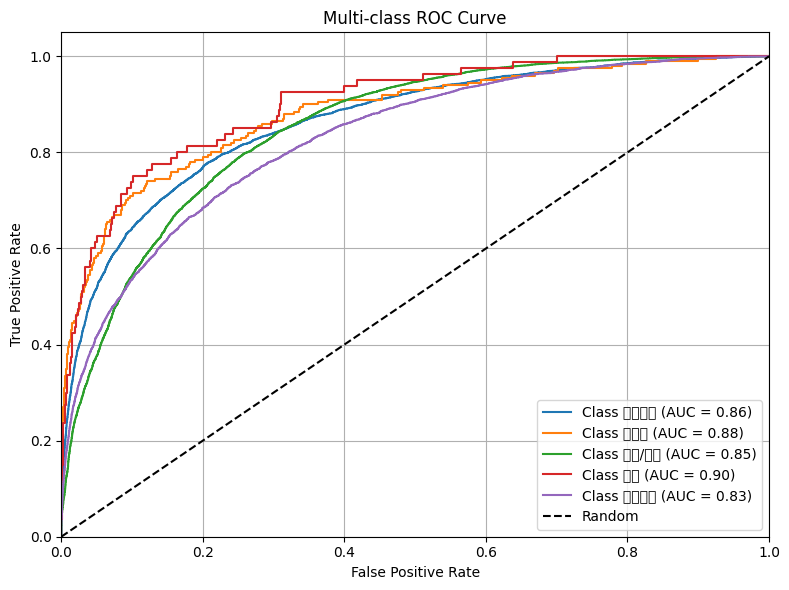

NameError: name 'evaluate_model' is not defined

In [ ]:
train_model(model, train_loader, val_loader, epochs=5, device=device)

In [ ]:
eval_model(model, val_loader, label_encoder, device)

NameError: name 'eval_model' is not defined

## 5.평가

- 적절한 평가 지표 설정 및 측정
- 클래스 별 ROC AUC를 하나의 플롯에 그리기

### 위 과정을 완성한 사람은 소분류 기준으로도 예측 모델을 만들어보세요.